In [2]:
import pandas as pd
import torch
from sklearn.decomposition import PCA
from tqdm import tqdm
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
import numpy as np
import seaborn as sns
import os
os.chdir('/Users/kate_fieseler/PycharmProjects/edboplus_scope/test/thompson_SNAr/figure_S2_train_test')

In [14]:
data = pd.read_csv('figure_S2.csv')

In [15]:
data

,"20C, 0h heat, DIPEA, NMP, r1",R1-B1,R1-B2,R1-B3,R1-B4,R1-B5,R1-B6,R1-B7,R1-B8,R1-B9,R1-B10,R1-B11,R1-B12 (S),R1-B12 (D)
0,R1-A1,31.7,28.0,24.5,868.6,17.8,23.0,3866.6,165.5,61.9,45.0,28.7,171.0,244.1
1,R1-A2,52.3,29.5,32.6,21.2,5.5,5.8,59.3,40.8,14.4,6.5,17.3,258.0,669.6
2,R1-A3,12.2,3.9,9.9,31.4,37.3,30.0,13.2,26.9,12.6,13.5,20.3,22.4,463.9
3,R1-A4,410.3,56.8,136.5,1041.5,58.5,55.7,40.7,28.7,1412.2,206.0,9.2,87.7,2215.1
4,R1-A5,24.3,6.6,5.3,135.1,32.6,30.6,44.0,9.5,31.2,30.9,28.3,51.0,116.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138,R1-A4,2030.4,455.3,643.6,7339.9,2065.5,6621.2,8273.6,59.7,49.6,241.1,36.2,55.3,50.0
139,R1-A5,47.8,30.3,37.9,74.6,27.6,43.0,8215.1,34.1,28.4,24.8,31.9,23.2,79.0
140,R1-A6,404.0,106.2,109.7,284.0,100.8,189.9,664.1,104.4,52.1,19.8,169.8,77.2,83.6
141,R1-A7,1228.6,311.6,174.9,4752.6,349.3,686.4,8343.6,92.1,82.6,64.6,49.7,30.1,103.2


In [16]:
data.iloc[8]

20C, 0h heat, DIPEA, NMP, r1    150C, 15h heat, DIPEA, NMP, r1
R1-B1                                                      NaN
R1-B2                                                      NaN
R1-B3                                                      NaN
R1-B4                                                      NaN
R1-B5                                                      NaN
R1-B6                                                      NaN
R1-B7                                                      NaN
R1-B8                                                      NaN
R1-B9                                                      NaN
R1-B10                                                     NaN
R1-B11                                                     NaN
R1-B12 (S)                                                 NaN
R1-B12 (D)                                                 NaN
Name: 8, dtype: object

In [58]:
def extract_rxn_conditions(old_df, df):
    # Extract metadata from the 0,0 entry
    print(df)
    if old_df is None:
        metadata = df.columns[0].split(", ")
    else:
        metadata = df.iloc[0,0].split(", ")
    print(metadata)
    T = metadata[0][:-1]
    time = metadata[1].split(" ")[0][:-1]
    base, solvent = metadata[2:4]
    round_num = metadata[4][1]
    
    # Create an empty DataFrame with the desired columns
    new_df = pd.DataFrame(columns=['A', 'B', 'solvent', 'base', 'T', 'time', 'round_num', 'peak_height'])
    
    # Populate the new DataFrame
    for col in df.columns[1:]:
        for index, row in df.iterrows():
            if "C" in row[0]:
                continue
            new_row = {
                'A': row[0],
                'B': col,
                'solvent': solvent,
                'base': base,
                'T': T,
                'time': time,
                'round_num': round_num,
                'peak_height': row[col]
            }
            new_df = new_df.append(new_row, ignore_index=True)
    
    if old_df is None:
        return new_df
    else:
        return old_df.append(new_df, ignore_index=True)
    

In [59]:
new_df = None
new_df = extract_rxn_conditions(None, data.iloc[:8])
for i in range(1, 16):
    print(i)
    new_df = extract_rxn_conditions(new_df, data.iloc[(i*9)-1:(i+1)*9-1])

  20C, 0h heat, DIPEA, NMP, r1  R1-B1  R1-B2  R1-B3   R1-B4  R1-B5  R1-B6  \
0                        R1-A1   31.7   28.0   24.5   868.6   17.8   23.0   
1                        R1-A2   52.3   29.5   32.6    21.2    5.5    5.8   
2                        R1-A3   12.2    3.9    9.9    31.4   37.3   30.0   
3                        R1-A4  410.3   56.8  136.5  1041.5   58.5   55.7   
4                        R1-A5   24.3    6.6    5.3   135.1   32.6   30.6   
5                        R1-A6   47.2   32.1   28.9    38.1   42.2   18.1   
6                        R1-A7   38.5   30.0   20.0  4690.9   29.1   26.7   
7                        R1-A8  124.2   14.8   14.4    19.4   26.7   30.4   

    R1-B7  R1-B8   R1-B9  R1-B10  R1-B11  R1-B12 (S)  R1-B12 (D)  
0  3866.6  165.5    61.9    45.0    28.7       171.0       244.1  
1    59.3   40.8    14.4     6.5    17.3       258.0       669.6  
2    13.2   26.9    12.6    13.5    20.3        22.4       463.9  
3    40.7   28.7  1412.2   206.0     9

In [60]:
new_df

,A,B,solvent,base,T,time,round_num,peak_height
0,R1-A1,R1-B1,NMP,DIPEA,20,0,1,31.7
1,R1-A2,R1-B1,NMP,DIPEA,20,0,1,52.3
2,R1-A3,R1-B1,NMP,DIPEA,20,0,1,12.2
3,R1-A4,R1-B1,NMP,DIPEA,20,0,1,410.3
4,R1-A5,R1-B1,NMP,DIPEA,20,0,1,24.3
...,...,...,...,...,...,...,...,...
1659,R1-A4,R1-B12 (D),"1,4-dioxane",None,150,15,1,50.0
1660,R1-A5,R1-B12 (D),"1,4-dioxane",None,150,15,1,79.0
1661,R1-A6,R1-B12 (D),"1,4-dioxane",None,150,15,1,83.6
1662,R1-A7,R1-B12 (D),"1,4-dioxane",None,150,15,1,103.2


In [61]:
new_df.to_csv('figure_S2_tidy.csv', index=False)

# Making 5 random train and test splits of 80/20

In [4]:
os.chdir('/Users/kate_fieseler/PycharmProjects/edboplus_scope/test/thompson_SNAr/')
df = pd.read_csv('figure_S2_tidy.csv')
df

,A,A_smiles,B,B_smiles,solvent,base,T,time,round_num,peak_height
0,R1-A1,N[C@@H]1CCCC[C@H]1N,R1-B1,CC(=O)c1ccc(F)cc1,NMP,DIPEA,20,0,1,31.7
1,R1-A2,Cn1ccnc1,R1-B1,CC(=O)c1ccc(F)cc1,NMP,DIPEA,20,0,1,52.3
2,R1-A3,C1CCNCC1,R1-B1,CC(=O)c1ccc(F)cc1,NMP,DIPEA,20,0,1,12.2
3,R1-A4,CN1CCNCC1,R1-B1,CC(=O)c1ccc(F)cc1,NMP,DIPEA,20,0,1,410.3
4,R1-A5,NCc1ccccc1,R1-B1,CC(=O)c1ccc(F)cc1,NMP,DIPEA,20,0,1,24.3
...,...,...,...,...,...,...,...,...,...,...
1531,R1-A4,CN1CCNCC1,R1-B12 (D),O=[N+]([O-])c1cnc(Cl)nc1Cl,"1,4-dioxane",None,150,15,1,50.0
1532,R1-A5,NCc1ccccc1,R1-B12 (D),O=[N+]([O-])c1cnc(Cl)nc1Cl,"1,4-dioxane",None,150,15,1,79.0
1533,R1-A6,Nc1cccnc1N,R1-B12 (D),O=[N+]([O-])c1cnc(Cl)nc1Cl,"1,4-dioxane",None,150,15,1,83.6
1534,R1-A7,CC1CCCCN1CCCN,R1-B12 (D),O=[N+]([O-])c1cnc(Cl)nc1Cl,"1,4-dioxane",None,150,15,1,103.2


In [64]:
num_splits = 5
train_test_splits = []

for _ in range(num_splits):
    # Randomly shuffle the indices
    shuffled_indices = torch.randperm(len(df))
    
    # Split indices into train and test
    split_idx = int(0.8 * len(df))
    train_indices = shuffled_indices[:split_idx]
    test_indices = shuffled_indices[split_idx:]
    
    # Extract train and test DataFrames based on indices
    train_df = df.iloc[train_indices]
    test_df = df.iloc[test_indices]
    
    train_test_splits.append((train_df, test_df))

In [65]:
for i, (train, test) in enumerate(train_test_splits):
    print(f"Split {i+1}")
    print("Train:", len(train))
    print("Test:", len(test))
    print("------")

Split 1
Train: 1331
Test: 333
------
Split 2
Train: 1331
Test: 333
------
Split 3
Train: 1331
Test: 333
------
Split 4
Train: 1331
Test: 333
------
Split 5
Train: 1331
Test: 333
------


In [66]:
for i, (train, test) in enumerate(train_test_splits):
    train.to_csv(f'figure_S2_train_{i+1}.csv', index=False)
    test.to_csv(f'figure_S2_test_{i+1}.csv', index=False)

# Add smiles for each reactant.

In [10]:
smiles = {
    'R1-A1': 'N[C@@H]1CCCC[C@H]1N',
    'R1-A2': 'Cn1ccnc1',
    'R1-A3': 'C1CCNCC1',
    'R1-A4': 'CN1CCNCC1',
    'R1-A5': 'NCc1ccccc1',
    'R1-A6': 'Nc1cccnc1N',
    'R1-A7': 'CC1CCCCN1CCCN',
    'R1-A8': 'c1ccc2[nH]cnc2c1',
    'R1-B1': 'CC(=O)c1ccc(F)cc1',
    'R1-B2': 'CC(=O)c1ccc(Cl)cc1',
    'R1-B3': 'CC(=O)c1ccc(Br)cc1',
    'R1-B4': 'O=[N+]([O-])c1ccc(F)cc1',
    'R1-B5': 'O=[N+]([O-])c1ccc(Cl)cc1',
    'R1-B6': 'O=[N+]([O-])c1ccc(Br)cc1',
    'R1-B7': 'CCc1ncnc(Cl)c1F',
    'R1-B8': 'Fc1ccc(C(F)(F)F)cc1',
    'R1-B9': 'FC(F)(F)c1ccc(Cl)cc1',
    'R1-B10': 'N#Cc1ccc(Br)cc1',
    'R1-B11': 'CCN(CC)c1ccc(Br)cc1',
    'R1-B12 (S)': 'O=[N+]([O-])c1cnc(Cl)nc1Cl',
    'R1-B12 (D)': 'O=[N+]([O-])c1cnc(Cl)nc1Cl',
}

In [79]:
def is_canonical(smiles):
    molecule = Chem.MolFromSmiles(smiles)
    canonical_smiles = Chem.MolToSmiles(molecule)
    return smiles == canonical_smiles

smiles_str = "CC(=O)c1ccc(F)cc1"   # example SMILES string
print(is_canonical(smiles_str))

True


In [8]:
# Add smiles as column to dataframes
for i in range(1, 6):
    train_df = pd.read_csv(f'figure_S2_train_{i}.csv')
    test_df = pd.read_csv(f'figure_S2_test_{i}.csv')
    
    train_df['A_smiles'] = train_df['A'].apply(lambda x: smiles[x])
    train_df['B_smiles'] = train_df['B'].apply(lambda x: smiles[x])
    test_df['A_smiles'] = test_df['A'].apply(lambda x: smiles[x])
    test_df['B_smiles'] = test_df['B'].apply(lambda x: smiles[x])
    
    test_df = test_df[['A', 'A_smiles', 'B', 'B_smiles', 'solvent', 'base', 'T', 'time', 'round_num', 'peak_height']]
    train_df = train_df[['A', 'A_smiles', 'B', 'B_smiles', 'solvent', 'base', 'T', 'time', 'round_num', 'peak_height']]
    
    train_df.to_csv(f'figure_S2_train_{i}.csv', index=False)
    test_df.to_csv(f'figure_S2_test_{i}.csv', index=False)

FileNotFoundError: [Errno 2] No such file or directory: 'figure_S2_train_1.csv'

In [7]:
# Make fp list
def fp_as_array(mol,n_bits=2048):
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=n_bits)
    arr = np.zeros((1,), int)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

def fp_list_from_smiles_list(smiles_list,n_bits=2048):
    fp_list = []
    for smiles in tqdm(smiles_list):
        mol = Chem.MolFromSmiles(smiles)
        fp_list.append(fp_as_array(mol,n_bits))
    return fp_list

fp_list = fp_list_from_smiles_list(list(smiles.values()))

NameError: name 'smiles' is not defined

In [6]:
# show T-SNE plot of amines and aryl halides, using first 50 PCs
sns.set(rc={'figure.figsize': (10, 10)})
sns.set(font_scale=1.5)
sns.set_style('whitegrid')

pca = PCA(n_components=50)
crds = pca.fit_transform(fp_list) 
from sklearn.manifold import TSNE
%time crds_embedded = TSNE(n_components=2).fit_transform(crds)

NameError: name 'fp_list' is not defined

# Add other representations of peak height data

In [11]:
os.chdir('/Users/kate_fieseler/PycharmProjects/edboplus_scope/test/thompson_SNAr')
df = pd.read_csv('figure_S2_tidy.csv')
df['A_smiles'] = df['A'].apply(lambda x: smiles[x])
df['B_smiles'] = df['B'].apply(lambda x: smiles[x])
df = df[['A', 'A_smiles', 'B', 'B_smiles', 'solvent', 'base', 'T', 'time', 'round_num', 'peak_height']]
df = df[df['B'].isin(['R1-B12 (S)']) == False]
df.to_csv(f'figure_S2_tidy.csv', index=False)

<Axes: xlabel='peak_height', ylabel='Count'>

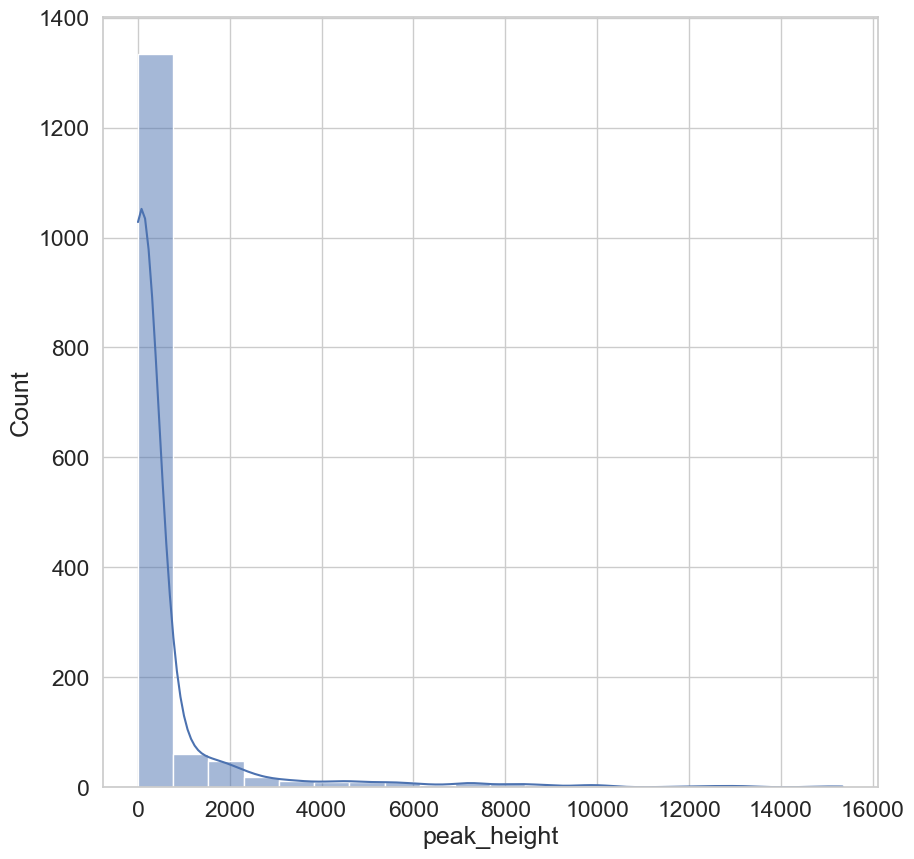

In [15]:
sns.set(rc={'figure.figsize': (10, 10)})
sns.set(font_scale=1.5)
sns.set_style('whitegrid')
# What is the distribution of peak heights?
sns.histplot(data=df, x='peak_height', bins=20, kde=True)

<Axes: xlabel='peak_height_scaled', ylabel='Count'>

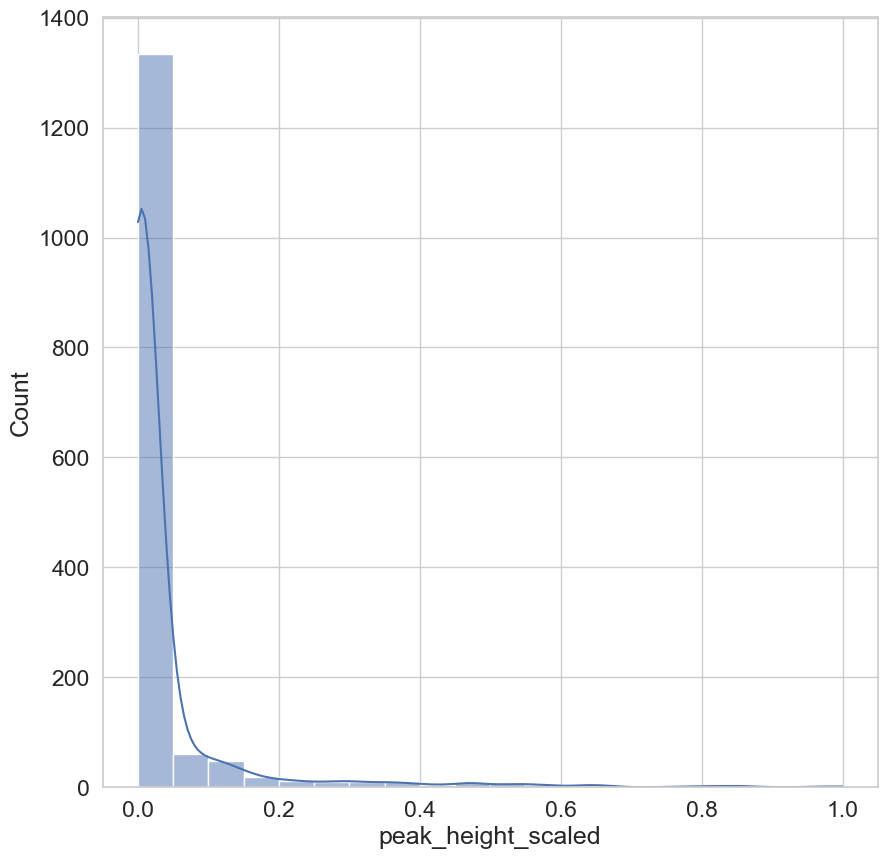

In [14]:
# Min-max scaling
df['peak_height_scaled'] = (df['peak_height'] - df['peak_height'].min()) / (df['peak_height'].max() - df['peak_height'].min())
sns.histplot(data=df, x='peak_height_scaled', bins=20, kde=True)

In [105]:
df['peak_height_scaled'].describe()

count    1536.000000
mean        0.035537
std         0.103522
min         0.000000
25%         0.001700
50%         0.003406
75%         0.013733
max         1.000000
Name: peak_height_scaled, dtype: float64

<Axes: xlabel='peak_height_log', ylabel='Count'>

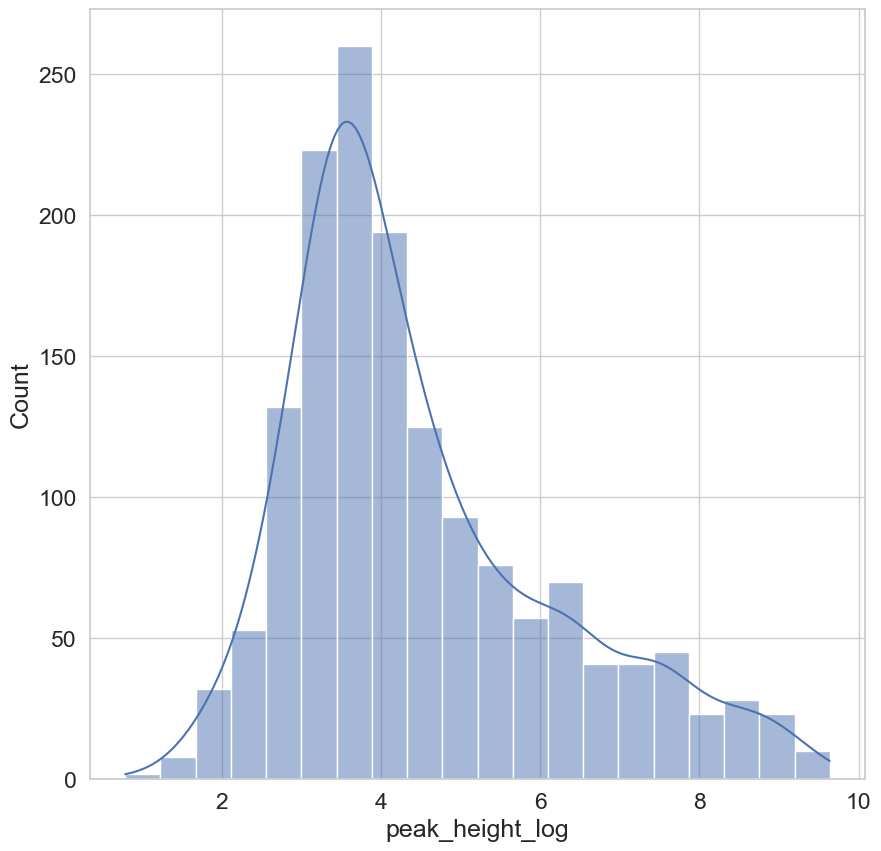

In [17]:
df['peak_height_log'] = np.log(df['peak_height'])
sns.histplot(data=df, x='peak_height_log', bins=20, kde=True)

In [19]:
df.to_csv(f'figure_S2_tidy.csv', index=False)
df

,A,A_smiles,B,B_smiles,solvent,base,T,time,round_num,peak_height,peak_height_scaled,peak_height_log
0,R1-A1,N[C@@H]1CCCC[C@H]1N,R1-B1,CC(=O)c1ccc(F)cc1,NMP,DIPEA,20,0,1,31.7,0.001923,3.456317
1,R1-A2,Cn1ccnc1,R1-B1,CC(=O)c1ccc(F)cc1,NMP,DIPEA,20,0,1,52.3,0.003266,3.956996
2,R1-A3,C1CCNCC1,R1-B1,CC(=O)c1ccc(F)cc1,NMP,DIPEA,20,0,1,12.2,0.000652,2.501436
3,R1-A4,CN1CCNCC1,R1-B1,CC(=O)c1ccc(F)cc1,NMP,DIPEA,20,0,1,410.3,0.026602,6.016889
4,R1-A5,NCc1ccccc1,R1-B1,CC(=O)c1ccc(F)cc1,NMP,DIPEA,20,0,1,24.3,0.001441,3.190476
...,...,...,...,...,...,...,...,...,...,...,...,...
1531,R1-A4,CN1CCNCC1,R1-B12 (D),O=[N+]([O-])c1cnc(Cl)nc1Cl,"1,4-dioxane",None,150,15,1,50.0,0.003116,3.912023
1532,R1-A5,NCc1ccccc1,R1-B12 (D),O=[N+]([O-])c1cnc(Cl)nc1Cl,"1,4-dioxane",None,150,15,1,79.0,0.005006,4.369448
1533,R1-A6,Nc1cccnc1N,R1-B12 (D),O=[N+]([O-])c1cnc(Cl)nc1Cl,"1,4-dioxane",None,150,15,1,83.6,0.005306,4.426044
1534,R1-A7,CC1CCCCN1CCCN,R1-B12 (D),O=[N+]([O-])c1cnc(Cl)nc1Cl,"1,4-dioxane",None,150,15,1,103.2,0.006584,4.636669


In [22]:
# Assuming df is your DataFrame and 'Original Data' is the column to be scaled
data = torch.tensor(df['peak_height'].values, dtype=torch.float32)

# Sort the data and get the indices
sorted_data, indices = torch.sort(data)

# Compute the quantile rank for each value
quantile_rank = torch.arange(1, len(data) + 1, dtype=torch.float32) / (len(data) + 1)

# Map the data to its quantile rank
quantile_scaled_data = torch.zeros_like(data)
quantile_scaled_data[indices] = quantile_rank

# Add the quantile-scaled data as a new column in the original DataFrame
df['peak_height_quantile_scaled'] = quantile_scaled_data.numpy()

df

,A,A_smiles,B,B_smiles,solvent,base,T,time,round_num,peak_height,peak_height_scaled,peak_height_log,Quantile Scaled Data,peak_height_quantile_scaled
0,R1-A1,N[C@@H]1CCCC[C@H]1N,R1-B1,CC(=O)c1ccc(F)cc1,NMP,DIPEA,20,0,1,31.7,0.001923,3.456317,0.303839,0.303839
1,R1-A2,Cn1ccnc1,R1-B1,CC(=O)c1ccc(F)cc1,NMP,DIPEA,20,0,1,52.3,0.003266,3.956996,0.482759,0.482759
2,R1-A3,C1CCNCC1,R1-B1,CC(=O)c1ccc(F)cc1,NMP,DIPEA,20,0,1,12.2,0.000652,2.501436,0.057254,0.057254
3,R1-A4,CN1CCNCC1,R1-B1,CC(=O)c1ccc(F)cc1,NMP,DIPEA,20,0,1,410.3,0.026602,6.016889,0.811321,0.811321
4,R1-A5,NCc1ccccc1,R1-B1,CC(=O)c1ccc(F)cc1,NMP,DIPEA,20,0,1,24.3,0.001441,3.190476,0.191282,0.191282
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1531,R1-A4,CN1CCNCC1,R1-B12 (D),O=[N+]([O-])c1cnc(Cl)nc1Cl,"1,4-dioxane",None,150,15,1,50.0,0.003116,3.912023,0.469096,0.469096
1532,R1-A5,NCc1ccccc1,R1-B12 (D),O=[N+]([O-])c1cnc(Cl)nc1Cl,"1,4-dioxane",None,150,15,1,79.0,0.005006,4.369448,0.595966,0.595966
1533,R1-A6,Nc1cccnc1N,R1-B12 (D),O=[N+]([O-])c1cnc(Cl)nc1Cl,"1,4-dioxane",None,150,15,1,83.6,0.005306,4.426044,0.609629,0.609629
1534,R1-A7,CC1CCCCN1CCCN,R1-B12 (D),O=[N+]([O-])c1cnc(Cl)nc1Cl,"1,4-dioxane",None,150,15,1,103.2,0.006584,4.636669,0.649317,0.649317


In [23]:
df.drop(columns=['Quantile Scaled Data'], inplace=True)

In [24]:
df

,A,A_smiles,B,B_smiles,solvent,base,T,time,round_num,peak_height,peak_height_scaled,peak_height_log,peak_height_quantile_scaled
0,R1-A1,N[C@@H]1CCCC[C@H]1N,R1-B1,CC(=O)c1ccc(F)cc1,NMP,DIPEA,20,0,1,31.7,0.001923,3.456317,0.303839
1,R1-A2,Cn1ccnc1,R1-B1,CC(=O)c1ccc(F)cc1,NMP,DIPEA,20,0,1,52.3,0.003266,3.956996,0.482759
2,R1-A3,C1CCNCC1,R1-B1,CC(=O)c1ccc(F)cc1,NMP,DIPEA,20,0,1,12.2,0.000652,2.501436,0.057254
3,R1-A4,CN1CCNCC1,R1-B1,CC(=O)c1ccc(F)cc1,NMP,DIPEA,20,0,1,410.3,0.026602,6.016889,0.811321
4,R1-A5,NCc1ccccc1,R1-B1,CC(=O)c1ccc(F)cc1,NMP,DIPEA,20,0,1,24.3,0.001441,3.190476,0.191282
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1531,R1-A4,CN1CCNCC1,R1-B12 (D),O=[N+]([O-])c1cnc(Cl)nc1Cl,"1,4-dioxane",None,150,15,1,50.0,0.003116,3.912023,0.469096
1532,R1-A5,NCc1ccccc1,R1-B12 (D),O=[N+]([O-])c1cnc(Cl)nc1Cl,"1,4-dioxane",None,150,15,1,79.0,0.005006,4.369448,0.595966
1533,R1-A6,Nc1cccnc1N,R1-B12 (D),O=[N+]([O-])c1cnc(Cl)nc1Cl,"1,4-dioxane",None,150,15,1,83.6,0.005306,4.426044,0.609629
1534,R1-A7,CC1CCCCN1CCCN,R1-B12 (D),O=[N+]([O-])c1cnc(Cl)nc1Cl,"1,4-dioxane",None,150,15,1,103.2,0.006584,4.636669,0.649317


In [29]:
quantile_labels = ['Q1', 'Q2', 'Q3', 'Q4']
df['quantile_category'] = pd.qcut(df['peak_height'], q=4, labels=quantile_labels)
df

,A,A_smiles,B,B_smiles,solvent,base,T,time,round_num,peak_height,peak_height_scaled,peak_height_log,peak_height_quantile_scaled,quantile_category
0,R1-A1,N[C@@H]1CCCC[C@H]1N,R1-B1,CC(=O)c1ccc(F)cc1,NMP,DIPEA,20,0,1,31.7,0.001923,3.456317,0.303839,Q2
1,R1-A2,Cn1ccnc1,R1-B1,CC(=O)c1ccc(F)cc1,NMP,DIPEA,20,0,1,52.3,0.003266,3.956996,0.482759,Q2
2,R1-A3,C1CCNCC1,R1-B1,CC(=O)c1ccc(F)cc1,NMP,DIPEA,20,0,1,12.2,0.000652,2.501436,0.057254,Q1
3,R1-A4,CN1CCNCC1,R1-B1,CC(=O)c1ccc(F)cc1,NMP,DIPEA,20,0,1,410.3,0.026602,6.016889,0.811321,Q4
4,R1-A5,NCc1ccccc1,R1-B1,CC(=O)c1ccc(F)cc1,NMP,DIPEA,20,0,1,24.3,0.001441,3.190476,0.191282,Q1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1531,R1-A4,CN1CCNCC1,R1-B12 (D),O=[N+]([O-])c1cnc(Cl)nc1Cl,"1,4-dioxane",None,150,15,1,50.0,0.003116,3.912023,0.469096,Q2
1532,R1-A5,NCc1ccccc1,R1-B12 (D),O=[N+]([O-])c1cnc(Cl)nc1Cl,"1,4-dioxane",None,150,15,1,79.0,0.005006,4.369448,0.595966,Q3
1533,R1-A6,Nc1cccnc1N,R1-B12 (D),O=[N+]([O-])c1cnc(Cl)nc1Cl,"1,4-dioxane",None,150,15,1,83.6,0.005306,4.426044,0.609629,Q3
1534,R1-A7,CC1CCCCN1CCCN,R1-B12 (D),O=[N+]([O-])c1cnc(Cl)nc1Cl,"1,4-dioxane",None,150,15,1,103.2,0.006584,4.636669,0.649317,Q3


<Axes: xlabel='peak_height_quantile_scaled', ylabel='peak_height'>

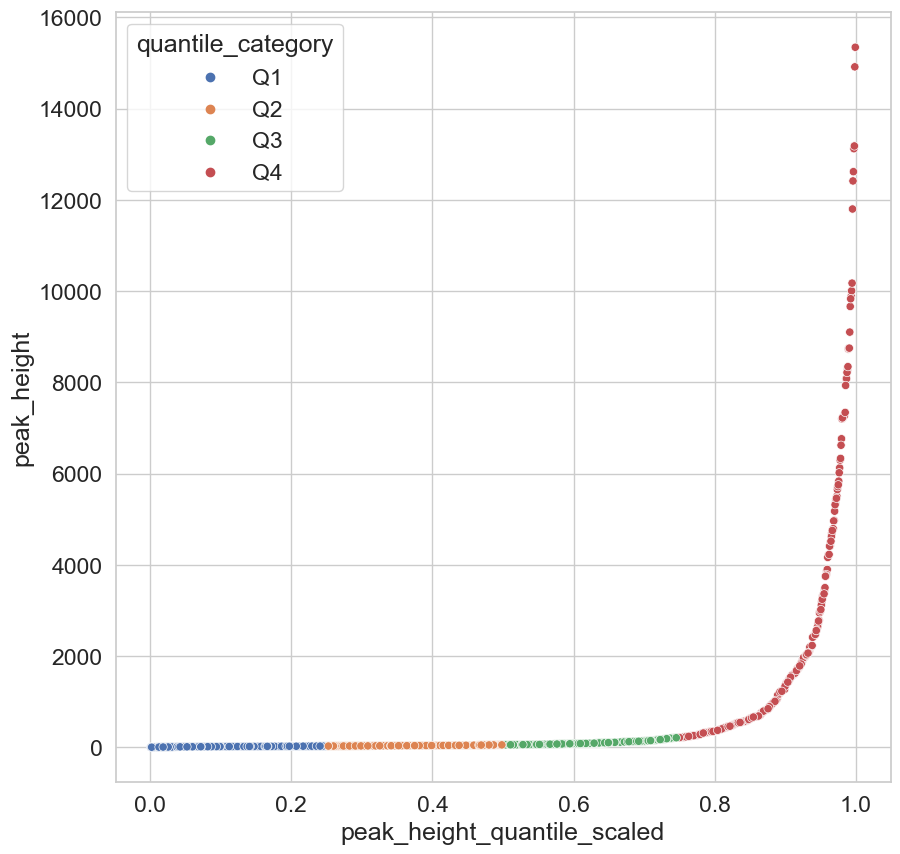

In [43]:
sns.set(rc={'figure.figsize': (10, 10)})
sns.set(font_scale=1.5)
sns.set_style('whitegrid')
sns.scatterplot(data=df, x='peak_height_quantile_scaled', y='peak_height', hue='quantile_category')

<Axes: xlabel='peak_height_quantile_scaled', ylabel='peak_height'>

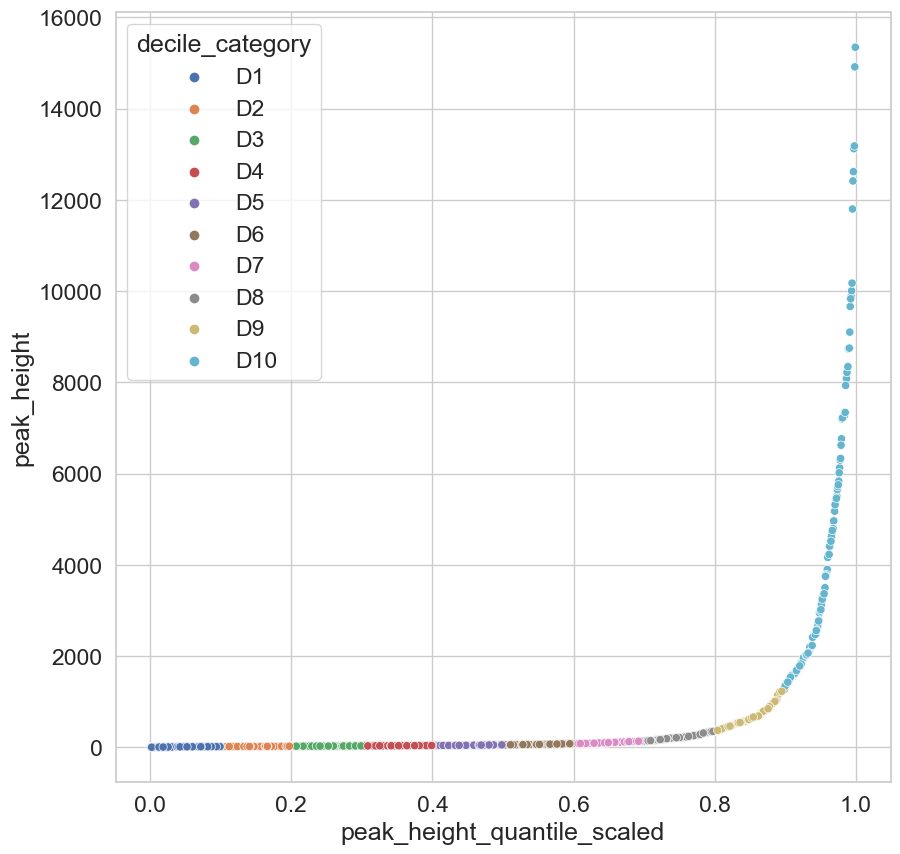

In [44]:
decile_labels = ['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10']
df['decile_category'] = pd.qcut(df['peak_height'], q=10, labels=decile_labels)
sns.scatterplot(data=df, x='peak_height_quantile_scaled', y='peak_height', hue='decile_category')

In [45]:
df.to_csv(f'figure_S2_tidy.csv', index=False)